In [1]:
!pip3 install torch torchvision

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
def load_data(data_files, label_files):
  data = np.array([])
  for data_file in data_files:
    if data.size == 0:
      data = np.load(data_file)
    else:
      data = np.append(data, np.load(data_file), axis=0)
  data = np.array([[i] for i in data])
  data = torch.from_numpy(data.astype(np.float32))

  labels = np.array([])
  for label_file in label_files:
    if labels.size == 0:
      labels = np.load(label_file)
    else:
      labels = np.append(labels, np.load(label_file), axis=0)
  labels = torch.from_numpy(labels.astype(np.long))

  train_data = data[:27000]
  train_labels = labels[:27000]

  test_data = data[27000:]
  test_labels = labels[27000:]

  trainset = torch.utils.data.TensorDataset(train_data,train_labels)
  testset = torch.utils.data.TensorDataset(test_data,test_labels)

  return trainset, testset

data_files = ['data0.npy', 'data1.npy', 'data2.npy']
label_files = ['lab0.npy', 'lab1.npy', 'lab2.npy']
trainset, testset = load_data(data_files, label_files)

In [19]:
def create_loader(trainset, testset, split_ratio = 0.8, BATCH_SIZE = 32):
  trainset, valset = torch.utils.data.random_split(trainset, [int(0.8 * len(trainset)), int(0.2 * len(trainset))])
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
  return trainloader, valloader, testloader

BATCH_SIZE = 32
trainloader, valloader, testloader = create_loader(trainset, testset, BATCH_SIZE = BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


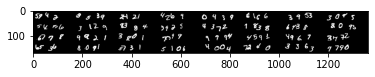

In [9]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_image(trainloader):
  dataiter = iter(trainloader)
  images, labels = dataiter.next()
  imshow(torchvision.utils.make_grid(images))

show_image(trainloader)

In [10]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 40, 168])
Image label dimensions: torch.Size([32])


In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.d1 = nn.Linear(40 * 168 * 1, 2000)
        self.d2 = nn.Linear(2000, 1000)
        self.d3 = nn.Linear(1000, 500)
        self.d4 = nn.Linear(500, 37)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        x = F.relu(x)
        x = self.d3(x)
        x = F.relu(x)
        logits = self.d4(x)
        out = F.softmax(logits, dim=1)

        return out

In [21]:
def test_model(trainloader, model):
  ## test the model with 1 batch
  for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

model = Model()
test_model(trainloader, model)

batch size: torch.Size([32, 1, 40, 168])
torch.Size([32, 37])


In [22]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
  ''' Obtain accuracy for training round '''
  corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
  accuracy = 100.0 * corrects/batch_size
  return accuracy.item()

In [23]:
def run_epochs(model, trainloader, valloader, criterion, optimizer, num_epochs = 100, BATCH_SIZE = 32):
  train_loss = list()
  val_loss = list()
  train_acc = list()
  val_acc = list()

  for epoch in tqdm(range(num_epochs)):
    total_train_loss = 0
    total_val_loss = 0

    total_train_acc = 0.0
    total_val_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
      
      images = images.to(device)
      labels = labels.to(device)
      ## forward + backprop + loss
      pred = model(images)
      loss = criterion(pred, labels)
      optimizer.zero_grad()
      loss.backward()
      ## update model params
      optimizer.step()
      total_train_loss += loss.detach().item()
      total_train_acc += get_accuracy(pred, labels, BATCH_SIZE)
    
    total_train_loss = total_train_loss/i
    total_train_acc = total_train_acc/i
    train_loss.append(total_train_loss)
    train_acc.append(total_train_acc)

    model.eval()

    ## validation step
    for i, (images, labels) in enumerate(valloader):
      
      images = images.to(device)
      labels = labels.to(device)
      ## forward + backprop + loss
      pred = model(images)
      loss = criterion(pred, labels)
      total_val_loss += loss.detach().item()
      total_val_acc += get_accuracy(pred, labels, BATCH_SIZE)

    total_val_loss = total_val_loss/i
    total_val_acc = total_val_acc/i
    val_loss.append(total_val_loss)
    val_acc.append(total_val_acc)

    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f | Val Loss: %.4f | Val Accuracy: %.2f' %(epoch, total_train_loss, total_train_acc, total_val_loss, total_val_acc )) 
  return train_loss, val_loss, train_acc, val_acc


In [24]:
## Defining Hyperparameters

learning_rate = 0.00001
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = run_epochs(model, trainloader, valloader, criterion, optimizer, num_epochs = num_epochs, BATCH_SIZE = BATCH_SIZE)

 10%|█         | 1/10 [00:11<01:43, 11.50s/it]

Epoch: 0 | Train Loss: 3.5921 | Train Accuracy: 6.57 | Val Loss: 3.6056 | Val Accuracy: 7.12


 20%|██        | 2/10 [00:22<01:31, 11.44s/it]

Epoch: 1 | Train Loss: 3.5658 | Train Accuracy: 9.15 | Val Loss: 3.6039 | Val Accuracy: 6.75


 30%|███       | 3/10 [00:34<01:19, 11.41s/it]

Epoch: 2 | Train Loss: 3.5112 | Train Accuracy: 15.40 | Val Loss: 3.6011 | Val Accuracy: 6.92


 40%|████      | 4/10 [00:45<01:08, 11.41s/it]

Epoch: 3 | Train Loss: 3.4521 | Train Accuracy: 21.80 | Val Loss: 3.6011 | Val Accuracy: 6.75


 50%|█████     | 5/10 [00:57<00:57, 11.42s/it]

Epoch: 4 | Train Loss: 3.4004 | Train Accuracy: 26.97 | Val Loss: 3.6021 | Val Accuracy: 6.58


 60%|██████    | 6/10 [01:08<00:45, 11.40s/it]

Epoch: 5 | Train Loss: 3.3578 | Train Accuracy: 31.26 | Val Loss: 3.5994 | Val Accuracy: 6.88


 70%|███████   | 7/10 [01:19<00:34, 11.43s/it]

Epoch: 6 | Train Loss: 3.3134 | Train Accuracy: 35.82 | Val Loss: 3.6005 | Val Accuracy: 6.75


 80%|████████  | 8/10 [01:31<00:22, 11.41s/it]

Epoch: 7 | Train Loss: 3.2706 | Train Accuracy: 40.08 | Val Loss: 3.6006 | Val Accuracy: 6.70


 90%|█████████ | 9/10 [01:42<00:11, 11.45s/it]

Epoch: 8 | Train Loss: 3.2334 | Train Accuracy: 43.65 | Val Loss: 3.6007 | Val Accuracy: 6.86


100%|██████████| 10/10 [01:54<00:00, 11.42s/it]

Epoch: 9 | Train Loss: 3.2034 | Train Accuracy: 46.41 | Val Loss: 3.6010 | Val Accuracy: 6.88


In [25]:
def get_test_acc(model, testloader):
  test_acc = 0.0
  for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
  return test_acc/i

acc = get_test_acc(model, testloader)
print('Test Accuracy: %.2f'%(acc))

Test Accuracy: 6.18


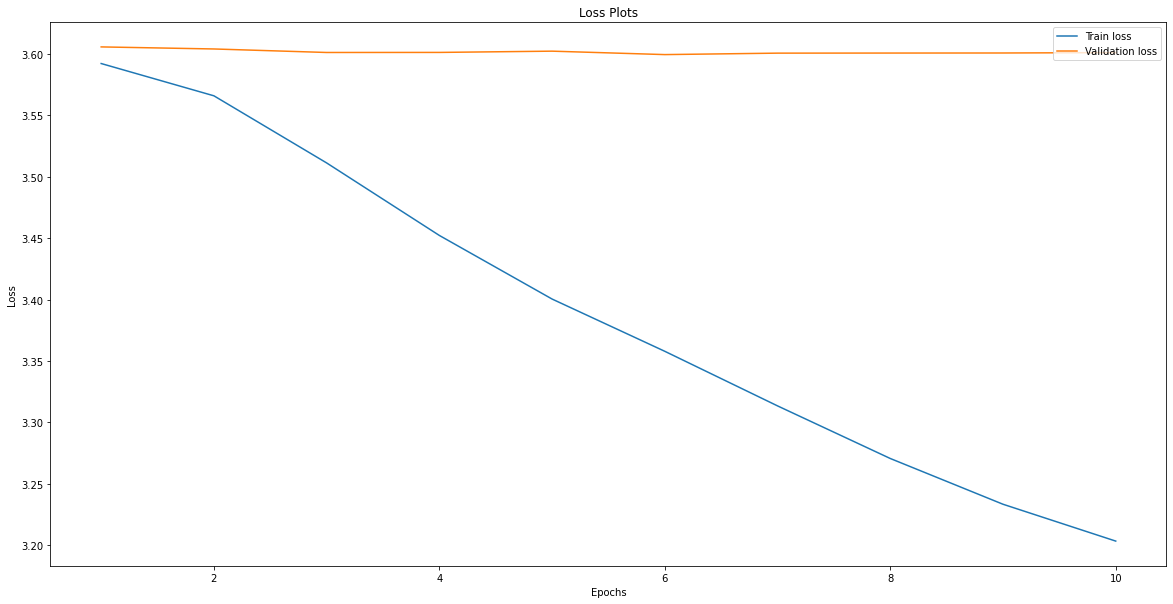

In [26]:
def get_loss_plot(train_loss, val_loss, num_epochs, IMG_NAME = 'loss.png'):
  fig=plt.figure(figsize=(20, 10))
  plt.plot(np.arange(1, num_epochs+1), train_loss, label="Train loss")
  plt.plot(np.arange(1, num_epochs+1), val_loss, label="Validation loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Loss Plots")
  plt.legend(loc='upper right')
  plt.savefig(IMG_NAME)

get_loss_plot(train_loss, val_loss, num_epochs, 'loss.png')

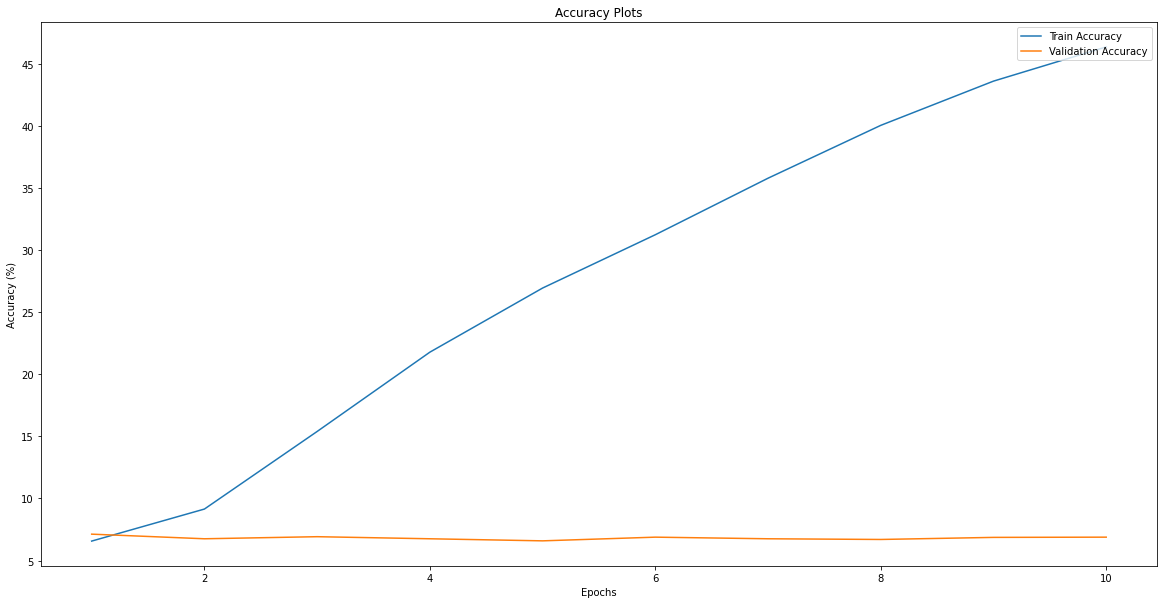

In [28]:
def get_acc_plot(train_acc, val_acc, num_epochs, IMG_NAME = 'acc.png'):
  fig=plt.figure(figsize=(20, 10))
  plt.plot(np.arange(1, num_epochs+1), train_acc, label="Train Accuracy")
  plt.plot(np.arange(1, num_epochs+1), val_acc, label="Validation Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title("Accuracy Plots")
  plt.legend(loc='upper right')
  plt.savefig(IMG_NAME)

get_acc_plot(train_acc, val_acc, num_epochs)

In [29]:
MODEL_NAME = 'model.dth'
torch.save(model.state_dict(), MODEL_NAME)

Test accuracy 6.18279570


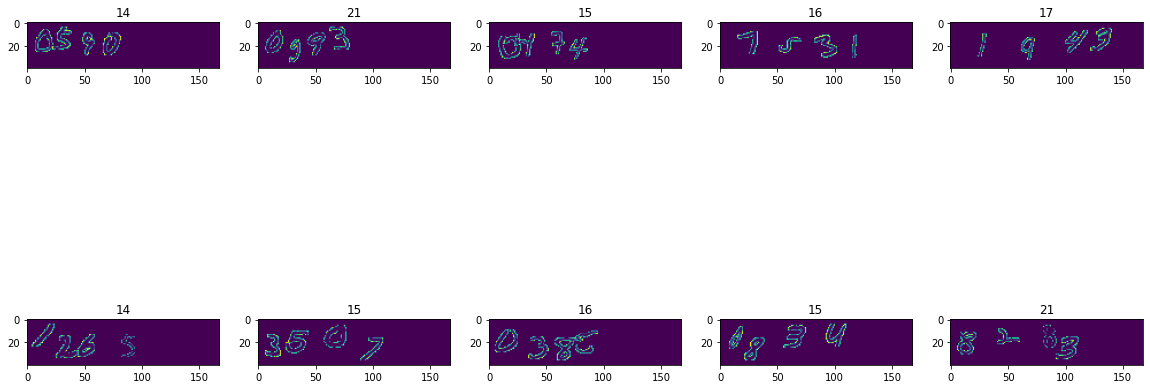

<Figure size 432x288 with 0 Axes>

In [43]:
def test_model(MODEL_NAME, testloader, IMG_NAME='result.png'):
  # test model
  model.load_state_dict(torch.load(MODEL_NAME))
  model.eval()

  results = list()
  test_acc = 0.0

  for itr, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    pred = model(images)
    pred = torch.nn.functional.softmax(pred, dim=1)
    test_acc += get_accuracy(pred, labels, BATCH_SIZE)

    for i, p in enumerate(pred):
      if labels[i] == torch.max(p.data, 0)[1]:
        results.append((images[i], torch.max(p.data, 0)[1]))

  print('Test accuracy {:.8f}'.format(test_acc/itr))

  # visualize data
  fig=plt.figure(figsize=(20, 10))
  for i in range(1, 11):
    img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0))
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
  plt.show()
  plt.savefig(IMG_NAME)

test_model(MODEL_NAME, testloader)